# 1. Imports
Nothing interesting here. 💤💤💤💤💤💤💤💤💤💤💤💤💤💤💤 ok stop sleeping there is also the rest of the notebook to walkthrough😜

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Efficientnet stuff
import efficientnet.tfkeras as efn
# Tensorflow Stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.backend as K
# Data Splitting Stuff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
# Image Handler Stuff
import matplotlib.pyplot as plt
import cv2
# Array Handler Stuff
import numpy as np
# Other stuff
import os
from tqdm import tqdm as tqdm
from functools import partial
import math
import re

Bunccha good ideas - 

https://www.kaggle.com/tuckerarrants/cassava-tensorflow-starter-training on mixup
https://www.kaggle.com/dimitreoliveira/cassava-leaf-supervised-contrastive-learning on contrastive learning

Good article - 
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet

# 2. TPU SETUP

Here are some excellent notebooks to refer - 
https://www.kaggle.com/awsaf49/efficientnetb6-512-cutmixupdropout-tpu-train

https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease/data

https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-training-with-tpu-v2-pods/notebook

https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-training

Other good notebooks but on gpu - 

https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
replicas = strategy.num_replicas_in_sync
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Some setup variables

The GCS Path thingy stuff explaination-

**TPUs read data directly from Google Cloud Storage (GCS), so we actually need to copy our dataset to a GCS 'bucket' that is near or 'co-located' with the TPU. The below chunk of code accomplishes this using the handy KaggleDatasets:**

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * replicas
IMAGE_SIZE = [512, 512]
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
CLASSES = ['0', '1', '2', '3', '4']
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_PATH)
print(BATCH_SIZE)

gs://kds-be94128ce773ab53f24c9b0a2aced4ad5bde5fc04d38f200b1c23181
16


# 3. Loading in our data

Some excellent notebooks on tfrecords

https://www.kaggle.com/ryanholbrook/tfrecords-basics

We are gonna load our data via tfrecords. Now tfrecords as tensorflow suggests is best to feed data to a TPU. So we are gonna go with that.🙂

### 1. Decode Image Function and Stuff
The following is a decoding function what it does is takes in an image in jpg form and converts it into an array. Unlike the numpy stuff you know.
Then the cast thingy converts the pixel thingies into floats so we can divide by a float that is 255.0 to normalize the stuff and all. You know normalization helps in training lol😂.

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

Well if you do not want to spend alot of time in understanding how tfrecords work just pick up other people's code use that to load data and then train and move forward.😜

### 2. Read tfrecord

Basically reads our tfrecord file and handles both for labelled and non labelled images.

In [6]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

### 3. Load Dataset from filenames Function
This just loads in data and thats all we need to know and this only handles for labelled images.

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

### 4. Make a list of train_filenames and val_filenames

The ```tf.io.gfile.glob``` is basically reading GCS path that is the GCS path to our Cassava competition data in which we have the train tfrecords. And then using the ```tf.io.gfile.glob``` we are getting a list of paths to our GCS path to the tfrecord where our TPU is located and then on top of that we use sklearns ```train_test_split``` to get buncha filenames for training and validation which we are later gonna load.

In [8]:
DATA = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')
print(len(DATA)) # Note that this is the number of tfrecord files which have actually a number of images in them

16


### 5. The Augmentation Functions - 

The following amazing function has been taken from this notebook - 
https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-training-with-tpu-v2-pods

Basically the vars at the starting like rotation, spatial p_pixel1 and so on are equating to a random number between 0 and 1.0 so what we get is a random number then the below ifs and elses are like if we get a number in the if's range to the var corresponding to its augmentation name then great we apply that augmentation. This brings in randomicity in the augmentations applied.
😀

In [9]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

#### Helper functions for the augmentation function -


In [10]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

### 6. Load Data Functions to now bring in our train, test data etc into variables and stuff

The following loads the training data. Remember the files we split recently into train files and others stuff files. So it will give the ```TRAINING_FILENAMES``` to the load_dataset function we created earlier with ```labelled = True``` as we know our training filenames are obviously gonna have labels.
Next ```dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE) ``` is applying our data_augment function to our dataset which we created earlier.
Then  we shuffle. Then we are breaking our dataset into batches we defined then we are finally returning our dataset

In [11]:
def get_data():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

This loads our validation data breaks it into batches and returns it to us.

In [12]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# 3. Explore the data

The following cells are just to count the data.

In [13]:
import re

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

NameError: name 'TRAINING_FILENAMES' is not defined

Look at a few images
The following are not at all an important piece of code.

In [15]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [16]:
# load our training dataset for visualisation
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)
# run this cell again for another randomized set of training images

NameError: name 'get_training_dataset' is not defined

In [17]:
display_batch_of_images(next(train_batch))

NameError: name 'train_batch' is not defined

In [18]:
# load our validation dataset for EDA
val_dataset = get_validation_dataset()
val_dataset = val_dataset.unbatch().batch(10)
test_batch = iter(val_dataset)
display_batch_of_images(next(test_batch))

NameError: name 'VALID_FILENAMES' is not defined

# 4. The Training
Here are our amazing plans - 
1. Use kfold crossvalidation. Makes it easy too to use ensemble learning
2. Bring in all the good stuff that people are doing 
3. Use EfficientNetB7, B4, Resnet and try to bring in Resnext

### 1. Callbacks - 

First of we are gonna make a learning rate scheduler callback. Here is what it is gonna do - 

1. Initial lr is 0.1
2. Will store loss in a dict
3. On every 10 batch end if loss did not reduce more than by 0.1 we make lr 10 times the present lr. Then after 3 batches check if lr improved by more than 0.1 or not. If it did we multiply present lr with a decay of 0.01. If it did not we bring back the lr which was there by multiplying present lr by 0.1
3. If after every 10 batch end if loss does improve we decay the present lr by 0.5

We would have liked that but that's much out of my mind how to make that code.
So we are going to go simple like this - 

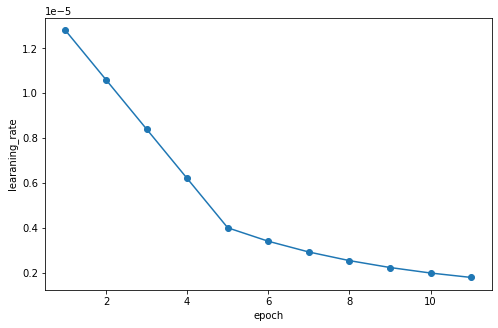

In [19]:
def get_lr_callback(batch_size=8, show = False):
    lr_start   = 0.000015000
    lr_max     = 0.000000250 * strategy.num_replicas_in_sync * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if show:
        plt.figure(figsize = (8, 5))
        plt.plot(np.arange(1, 12), [lrfn(x) for x in np.arange(1, 12)], marker = 'o')
        plt.xlabel('epoch')
        plt.ylabel('learaning_rate');
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(batch_size=BATCH_SIZE, show = True)

Next a model checkpoint. But we won't be needing one as the kerastuner package saves everything for us. Next tensorboard and all other good stuff

In [20]:
tensorboard = TensorBoard(log_dir='logs_v0.2/')
reducelr = ReduceLROnPlateau(patience=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience = 3, mode = 'min')

### The model architecture - 

In [21]:
# from keras.utils.vis_utils import plot_model
def build_model():
    input_shape = (HEIGHT, WIDTH, 3)
    N_CLASSES = 5
    inputs = Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    base_model.trainable = False

    x = Dropout(.5)(base_model.output)
    output = Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

seed stuff nothing important - 

In [22]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)

## K fold cross validation - 
Good articles - 
https://machinelearningmastery.com/out-of-fold-predictions-in-machine-learning/

Good Videos - 

https://www.youtube.com/watch?v=gJo0uNL-5Qw

https://www.youtube.com/watch?v=maiQf8ray_s

We might be freezing batchnorms of efficientnet. Here is a good answer why - 

https://stackoverflow.com/questions/63016740/why-its-necessary-to-frozen-all-inner-state-of-a-batch-normalization-layer-when

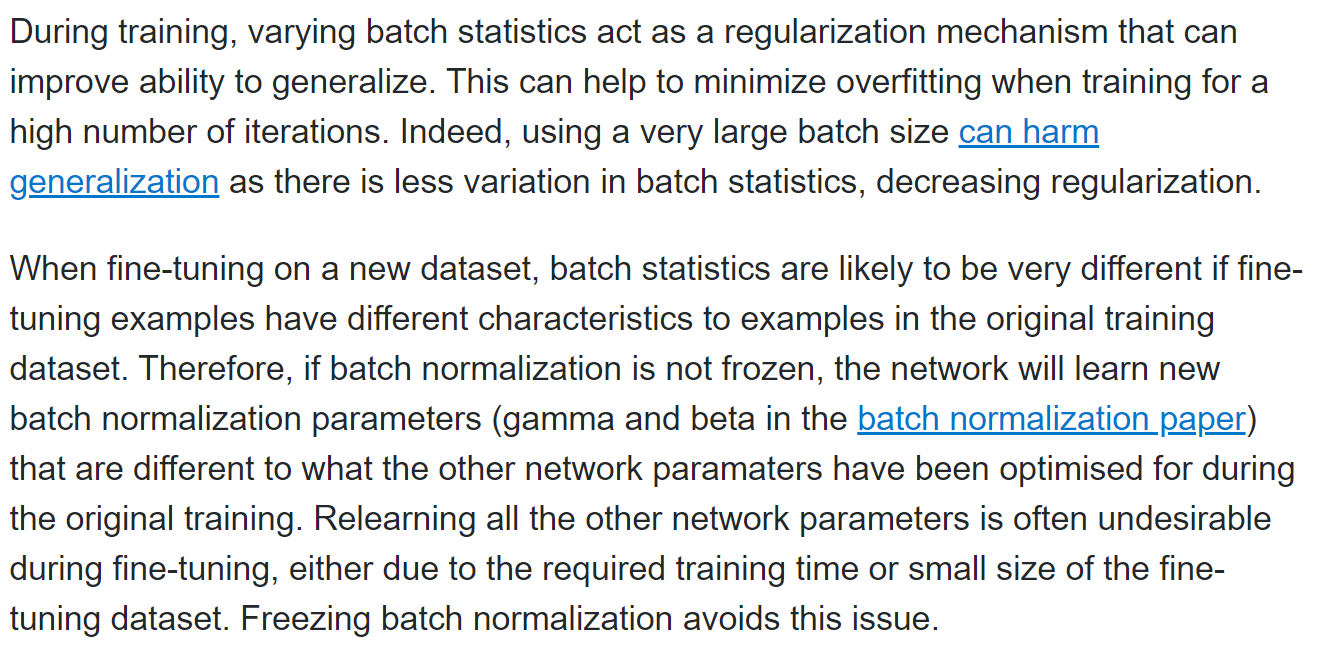

In [23]:
train_data = get_training_dataset()
valid_data = get_validation_dataset()

NameError: name 'get_training_dataset' is not defined

In [24]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

NameError: name 'NUM_TRAINING_IMAGES' is not defined

In [25]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(len(NUM_TRAINING_IMAGES))):
    print()
    print(f"FOLD: {fold+1}")
    print()
    print(len(train_idx))
    print(len(val_idx))

NameError: name 'NUM_TRAINING_IMAGES' is not defined